In [22]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import dataLoader as dl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#from Inner_Speech_Dataset.Plotting.ERPs import 
from Inner_Speech_Dataset.Python_Processing.Data_extractions import  Extract_data_from_subject
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time
from Inner_Speech_Dataset.Python_Processing.Data_processing import  Calculate_power_windowed
from Inner_Speech_Dataset.Python_Processing.Utilitys import picks_from_channels
from Inner_Speech_Dataset.Python_Processing.Data_processing import Average_in_frec

In [23]:
#Frequencies

from scipy.fft import rfft, ifft, fftshift, fftfreq


#Separate into equal 5 buckets
def sepFreqIndexBuckets(freqs2, nr_of_buckets = 5): 
     
    bucket_size_amp = np.sum(freqs2)/nr_of_buckets
    #print(bucket_size_amp)
    
    buckets = np.zeros([nr_of_buckets, 2])
    bucket = []
    cur_buck_size = 0
    
    b = 0
    c = 0
    for index, freqs in enumerate(freqs2,0):
        cur_buck_size += freqs
        bucket.append(index)
        if cur_buck_size > bucket_size_amp:
            buckets[b] = [0 + c , c + len(bucket)]
            b += 1
            c += len(bucket)
            #print(len(bucket))
            bucket = []
            cur_buck_size = 0
            
    
    buckets[b] = [0 + c , c + len(bucket)]
    #print(len(bucket)) 
       
    return buckets  




def createFreqBuckets(data, nr_of_buckets = 5):


    nr_of_buckets = 5
    buckets = np.zeros([nr_of_buckets, 2])
    for trial in data:
        for channel in trial:
            buckets += sepFreqIndexBuckets(abs(rfft(channel))[:(channel.shape[0]//2)]*1000, nr_of_buckets)
            
    buckets = buckets/(data.shape[0]*data.shape[1])
    
    
    return np.int32(buckets)


def data_into_freq_buckets(data, nr_of_buckets, buckets):

    freqAmps = np.zeros([data.shape[0], data.shape[1], nr_of_buckets])
    for tr_nr, trial in enumerate(data):
        for ch_nr, channel in enumerate(trial):
            for b in range(nr_of_buckets):
                ff_c = abs(rfft(channel))*1000
                freqAmps[tr_nr, ch_nr, b] = np.sum(ff_c[int(buckets[b, 0]):int(buckets[b,1])])
    return freqAmps


In [24]:
#Channel name array

def arrToDict(arr):
    dict = {}
    for row in arr:
        dict[row[0]] = row[1]
    
    return dict

def get_channelNames():
    ch_names = np.array(dl.get_channelnames())
    nr = np.arange(ch_names.shape[0])
    ch_names = np.array([ch_names, nr]).T
    ch_names = arrToDict(ch_names)
    return ch_names

def only_spec_channel_data(data , picks):
    
    channel_names_string = picks_from_channels(picks)
    ch_names = get_channelNames()
    channel_nr = []
    for name in  channel_names_string:
        channel_nr.append(int(ch_names[name]))
        #print(ch_names[name])

    channel_nr = np.array(channel_nr)
    
    #print(channel_nr)
    #data = np.swapaxes(data, 0, 1)
    #labels = np.swapaxes(labels, 0, 1)
    #for channelnrs in channels:
    data2 = np.delete(data, np.delete(np.arange(128), channel_nr) , axis=1)
    return data2


def get_power_array(split_data , samplingRate, trialSplit = 1, t_min = 0, t_max = 0.99):

    #trialSplit = 16
    sR = samplingRate #samplingRate = 32
    data_power = np.zeros([split_data.shape[0], split_data.shape[1], trialSplit, 2])
    for t, trial in enumerate(split_data,0):
        for c, channel in enumerate(trial,0):
            for x in range(trialSplit):
                data_power[t, c, x, : ] = Calculate_power_windowed(channel, fc=sR, window_len=1/8, window_step=1/8, t_min=t_min*(1/trialSplit), t_max=t_max*(1/trialSplit))


    #m_power , std_power
    #print(data_power.shape)
    return data_power
    


#Loading the data and labels from EEG and EXG

# data1, labels1 = dl.load_data(datatype="EEG", subject_nr=1, verbose=True,sampling_rate=sampling_rate) 
# data2, labels2 = dl.load_data(datatype="EEG", subject_nr=2 ,verbose=True,sampling_rate=sampling_rate )
# data4 , labels4 = dl.load_data(datatype="EEG", subject_nr=4, verbose=True,sampling_rate=sampling_rate) 

# dataX, labelsX = dl.load_data(datatype="EXG", verbose=False) 
# #datab, labelsb = dl.load_data(datatype="baseline", verbose=False, sampling_rate=32) 
# #dl.load_data(datatype2=2) #4.5 is max

####

#data = np.concatenate([data1, data2, data4], axis = 0)
#labels1d = np.concatenate([labels1, labels2, labels4], axis = 0)

####

#data = data1
#labels1d = labels1

sampling_rate = 128
data, labels = dl.load_multiple_datasets(nr_of_datasets=8, sampling_rate=sampling_rate, t_min=2, t_max=3)

ch_names = get_channelNames()

# print(data.shape)
# dataCL = only_spec_channel_data(data, "CL")
# dataCZ = only_spec_channel_data(data, "CZ")
# dataPZ = only_spec_channel_data(data, "PZ")
# dataOPZ = only_spec_channel_data(data, "OPZ")

# def avg_channels(data):
#     avg_data = np.mean(data, axis=1)
#     print(avg_data.shape)
#     return np.reshape(avg_data, [avg_data.shape[0], 1 , avg_data.shape[1]])

# data = np.concatenate([avg_channels(dataCL), avg_channels(dataCZ),
#                 avg_channels(dataPZ), avg_channels(dataOPZ),], axis=1)
# print(data.shape)

#Not work when time is not 4.5 right now kinda
print(data.shape)
data_p =  get_power_array(data, sampling_rate, trialSplit=1).squeeze()
print(data_p.shape)
#print(data_p[:,:,1])

#Getting Freq Data 
nr_of_buckets = 5
buckets = createFreqBuckets(data, nr_of_buckets)
print("buckets")
print(buckets)
data_f = data_into_freq_buckets(data, nr_of_buckets, buckets)
print(data_f.shape)


## Normalize data



Data shape: [trials x channels x samples]
(500, 128, 128)
Labels shape
(500, 4)
Final data shape
(100, 128, 128)
Final labels shape
(100,)
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0
Up is 0.0 and Down is 1.0
(788, 128, 128)
(788, 128, 2)
buckets
[[ 0  3]
 [ 3  9]
 [ 9 21]
 [21 41]
 [40 63]]
(788, 128, 5)


In [25]:
print(data_f.shape)
print(data_p.shape)
print(labels.shape)
print(data_p[2,5])
data = np.concatenate([data_f, data_p, data], axis =2 )
print(data.shape)
data = keras.utils.normalize(data, axis=1, order=2)
print(data.shape)
#print(data[2,5])
#print(labels[2])
print(labels[:].shape)

(788, 128, 5)
(788, 128, 2)
(788, 2)
[1.01648499e-10 5.52805943e-11]
(788, 128, 135)
(788, 128, 135)
(788, 2)


In [26]:
# def get_local_frequency(split_data , samplingRate, trialSplit = 2,):

#     #trialSplit = 16
#     sR = samplingRate #samplingRate = 32
#     data_power = np.zeros([split_data.shape[0], split_data.shape[1], trialSplit, 2])
#     for t, trial in enumerate(split_data,0):
#         for c, channel in enumerate(trial,0):
#             for x in range(trialSplit):
#                 data_power[t, c, x, : ] = Calculate_power_windowed(channel, fc=sR, window_len=1*4/trialSplit, window_step=1*4/trialSplit, t_min=0, t_max=4/trialSplit * x + 4/trialSplit)
    

#     #m_power , std_power
#     #print(data_power.shape)
#     return data_power
    

In [27]:
#Splitting into training and test data
#print(labels)


order = np.arange(labels.shape[0])
np.random.shuffle(order)

temp_data = np.zeros(data.shape)
temp_labels = np.zeros(labels.shape)

for x in range(labels.shape[0]):
    i = order[x]
    
    temp_data[x] = data[i]
    temp_labels[x] = labels[i]

data = temp_data
labels = temp_labels

data_train, data_test = np.split(data, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
labels_train, labels_test = np.split(labels, indices_or_sections=[int(labels.shape[0]*0.75)],axis=0)
print(labels_train.shape)
print(data_train.shape)
print(data_test.shape)




(591, 2)
(591, 128, 135)
(197, 128, 135)


In [28]:
#Convolution part

# Do the convs like I wrote in the Note
# First need to find out 8 best channels
#  Utilities can help average similar channels
# Read through article and how they did it better!
# convlayer = tf.keras.layers.Conv2D(4,
#  kernel_size=[2,1], input_shape= (data_train.shape[0], data_train.shape[1] , data_train.shape[2], 1,), 
#  padding="valid", strides=[round(data_train.shape[1]),1],
#  activation="relu")


# print(data_train.shape)
# print(data_test.shape)

# #data_train = np.swapaxes(data_train, 2, 1)
# #data_test = np.swapaxes(data_test, 2, 1)
# print(data_train.shape)
# print(data_test.shape)
# data_train = np.expand_dims(data_train, axis=0)
# data_test = np.expand_dims(data_test, axis=0)
# data_train = np.moveaxis(data_train, 0, -1)
# data_test = np.moveaxis(data_test, 0, -1)

# conv_data_train = convlayer(data_train)
# conv_data_test = convlayer(data_test)

# data_train = conv_data_train
# data_test = conv_data_test

# #data_train = np.swapaxes(data_train, 2, 1)
# #data_test = np.swapaxes(data_test, 2, 1)


# data_train = np.squeeze(np.moveaxis(data_train, -1, 0))
# data_test = np.squeeze(np.moveaxis(data_test, -1, 0))
# print(data_train.shape)
# print(data_test.shape)

In [29]:


# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

# tf.keras.backend.clear_session()





# eeg_model = tf.keras.Sequential([
    
#     #layers.Conv2D(500,
#     #kernel_size=[1,8], input_shape= (1, data_train.shape[1], data_train.shape[2], 1,), 
#     #padding="valid", strides=[1,4],
#     #activation="relu"),
#     # layers.Conv2D(200,
#     # kernel_size=[1,32], 
#     # padding="valid", strides=1,
#     # activation="relu"),
#     # layers.Conv2D(200,
#     # kernel_size=[1,32], 
#     # padding="valid", strides=1,
#     # activation="relu"),
#     # layers.Conv2D(200,
#     # kernel_size=[1,32], 
#     # padding="valid", strides=4,
#     # activation="relu"),
#     layers.LocallyConnected1D(56, input_shape = (data_train.shape[1],data_train.shape[2]), 
#      kernel_size=50, 
#      padding="valid", strides=1,
#      activation="relu"),
#     layers.Dropout(0.2),
#     #layers.Flatten(input_shape = (data_train.shape[1],data_train.shape[2])),
#     #layers.Dense(units=28*3, activation="relu"),
#     #layers.Dropout(0.3),
#     layers.Dense(units=500, activation="relu"),
#     layers.Dropout(0.2),
#     layers.LocallyConnected1D(56, 
#     kernel_size=30, 
#     padding="valid", strides=1,
#     activation="relu"),
#     layers.Dropout(0.2),
#     layers.Dense(units=500, activation="relu"),
#     layers.Dropout(0.2),
#     layers.LocallyConnected1D(56, 
#     kernel_size=20, 
#     padding="valid", strides=1,
#     activation="relu"),
#     layers.Dropout(0.2),
#     layers.Dense(units=500, activation="relu"),
#     layers.Dropout(0.2),
#     #layers.Dense(units=20, activation="relu"),
#     #layers.Dense(units=5, activation="relu"),
#     #layers.Dense(units=1, activation="relu"),
#     layers.Flatten(),
#     # layers.Dropout(0.4),
#     # layers.Dense(units=28*28, activation="relu"),
#     # layers.Dropout(0.4),
#     # layers.Dense(units=28, activation="relu"),
#     # layers.Dropout(0.4),
#     layers.Dense(units=2, activation="softmax")


# ])
# eeg_model.build()
# eeg_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected1d (Locall  (None, 79, 56)           29866424  
 yConnected1D)                                                   
                                                                 
 dropout (Dropout)           (None, 79, 56)            0         
                                                                 
 dense (Dense)               (None, 79, 500)           28500     
                                                                 
 dropout_1 (Dropout)         (None, 79, 500)           0         
                                                                 
 locally_connected1d_1 (Loca  (None, 50, 56)           42002800  
 llyConnected1D)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 50, 56)            0

In [42]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.clear_session()





eeg_model = tf.keras.Sequential([
    
    #layers.Conv2D(500,
    #kernel_size=[1,8], input_shape= (1, data_train.shape[1], data_train.shape[2], 1,), 
    #padding="valid", strides=[1,4],
    #activation="relu"),
    # layers.Conv2D(200,
    # kernel_size=[1,32], 
    # padding="valid", strides=1,
    # activation="relu"),
    # layers.Conv2D(200,
    # kernel_size=[1,32], 
    # padding="valid", strides=1,
    # activation="relu"),
    # layers.Conv2D(200,
    # kernel_size=[1,32], 
    # padding="valid", strides=4,
    # activation="relu"),
    layers.LocallyConnected1D(56, input_shape = (data_train.shape[1],data_train.shape[2]), 
     kernel_size=50, 
     padding="valid", strides=1,
     activation="relu"),
    layers.Dropout(0.7),
    #layers.Flatten(input_shape = (data_train.shape[1],data_train.shape[2])),
    #layers.Dense(units=28*3, activation="relu"),
    #layers.Dropout(0.3),
    layers.Dense(units=500, activation="relu"),
    layers.Dropout(0.7),
    layers.LocallyConnected1D(56, 
    kernel_size=30, 
    padding="valid", strides=1,
    activation="relu"),
    layers.Dropout(0.7),
    layers.Dense(units=500, activation="relu"),
    layers.Dropout(0.7),
    layers.LocallyConnected1D(56, 
    kernel_size=20, 
    padding="valid", strides=1,
    activation="relu"),
    layers.Dropout(0.7),
    layers.Dense(units=500, activation="relu"),
    layers.Dropout(0.7),
    #layers.Dense(units=20, activation="relu"),
    #layers.Dense(units=5, activation="relu"),
    #layers.Dense(units=1, activation="relu"),
    layers.Flatten(),
    # layers.Dropout(0.4),
    # layers.Dense(units=28*28, activation="relu"),
    # layers.Dropout(0.4),
    # layers.Dense(units=28, activation="relu"),
    # layers.Dropout(0.4),
    layers.Dense(units=2, activation="softmax")


])
eeg_model.build()
eeg_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected1d (Locall  (None, 79, 56)           29866424  
 yConnected1D)                                                   
                                                                 
 dropout (Dropout)           (None, 79, 56)            0         
                                                                 
 dense (Dense)               (None, 79, 500)           28500     
                                                                 
 dropout_1 (Dropout)         (None, 79, 500)           0         
                                                                 
 locally_connected1d_1 (Loca  (None, 50, 56)           42002800  
 llyConnected1D)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 50, 56)            0

In [ ]:
# for trialNr, trial in enumerate(data_train[46:47],1):
#     for channel in trial[3:4]:
#         plt.figure()
#         plt.plot(channel)
#         plt.title("EEG {}".format(labels_train[trialNr]))

# print(labels[2])
# print(labels[:].shape)

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
callback2 = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, restore_best_weights=True)
#tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=2)

eeg_model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])

data_train_send = np.reshape(data_train, [data_train.shape[0], 1 , data_train.shape[1], data_train.shape[2], 1])
#data_train_send = np.reshape(data_train, [data_train.shape[0], 1 , data_train.shape[1], data_train.shape[2], 1])

data_test_send = np.reshape(data_test, [data_test.shape[0], 1 , data_test.shape[1], data_test.shape[2], 1])
#data_test_send = np.reshape(data_test, [data_test.shape[0], 1 , data_test.shape[1], data_test.shape[2], 1])

outputs = eeg_model.fit(data_train, labels_train, callbacks=[callback, callback2], epochs=50) #

print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)

Epoch 1/50
19/19 [==============================] - 17s 777ms/step - loss: 0.7134 - accuracy: 0.5042
Epoch 2/50
19/19 [==============================] - 15s 766ms/step - loss: 0.6977 - accuracy: 0.5212
Epoch 3/50
19/19 [==============================] - 14s 760ms/step - loss: 0.6862 - accuracy: 0.5567
Epoch 4/50
19/19 [==============================] - 14s 761ms/step - loss: 0.7178 - accuracy: 0.6041
Epoch 5/50
19/19 [==============================] - 15s 768ms/step - loss: 0.6195 - accuracy: 0.6920
Epoch 6/50
19/19 [==============================] - 15s 770ms/step - loss: 0.5847 - accuracy: 0.7276
Epoch 7/50
19/19 [==============================] - 15s 774ms/step - loss: 0.4891 - accuracy: 0.8037
Epoch 8/50
19/19 [==============================] - 15s 768ms/step - loss: 0.4517 - accuracy: 0.8088
Epoch 9/50
19/19 [==============================] - 15s 765ms/step - loss: 0.4291 - accuracy: 0.8393
Epoch 10/50
19/19 [==============================] - 15s 763ms/step - loss: 0.4676 - accura

In [39]:

eeg_model.save('saved_model/my_model5')

INFO:tensorflow:Assets written to: saved_model/my_model4\assets


In [33]:
print("Results")
eeg_model.evaluate(data_test, labels_test)
result = eeg_model.predict(data_test)

result2 = []
print(result)
for res in result:
    x = np.maximum(res[0], res[1])
    result2.append(int(np.where(res == x)[0]))

result2 = np.array(result2)
print(result2)

Results
7/7 [==============================] - 2s 331ms/step
[[9.96008515e-01 3.99144413e-03]
 [5.70824509e-03 9.94291782e-01]
 [6.94612041e-03 9.93053854e-01]
 [9.55897570e-03 9.90441084e-01]
 [6.15297060e-04 9.99384642e-01]
 [9.95270073e-01 4.72995592e-03]
 [2.97675431e-01 7.02324569e-01]
 [6.34402156e-01 3.65597874e-01]
 [2.12426499e-01 7.87573516e-01]
 [1.44809812e-01 8.55190217e-01]
 [9.90262389e-01 9.73763037e-03]
 [1.68007333e-02 9.83199298e-01]
 [2.55179465e-01 7.44820535e-01]
 [3.57831828e-02 9.64216769e-01]
 [9.93169427e-01 6.83060614e-03]
 [3.22931483e-02 9.67706919e-01]
 [4.32243804e-03 9.95677531e-01]
 [1.04863495e-02 9.89513636e-01]
 [9.87975776e-01 1.20242545e-02]
 [9.42642450e-01 5.73575981e-02]
 [4.16855782e-01 5.83144248e-01]
 [1.01338839e-02 9.89866197e-01]
 [9.75548863e-01 2.44511627e-02]
 [4.67925239e-03 9.95320737e-01]
 [9.93232250e-01 6.76772790e-03]
 [8.97624671e-01 1.02375269e-01]
 [2.84155700e-02 9.71584499e-01]
 [9.47571695e-01 5.24282716e-02]
 [5.47089353e-0

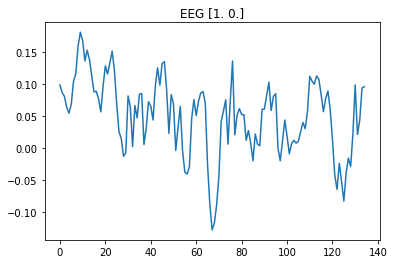

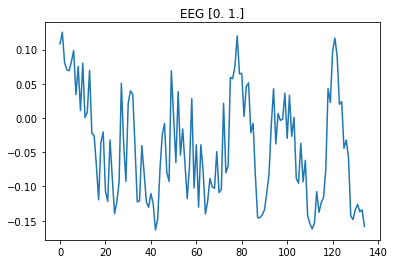

In [34]:


for trialNr, trial in enumerate(data[44:46],44):
    for channel in trial[5:6]:
        plt.figure()
        plt.plot(channel)
        plt.title("EEG {}".format(labels[trialNr]))

      